In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression

In [13]:
import pickle
with open('train_flip.pickle','rb') as read_file:
    train = pickle.load(read_file)
with open('test_flip.pickle','rb') as read_file:
    test = pickle.load(read_file)

In [14]:
train = train.drop(columns=['hearing']).sample(50000)
test = test.drop(columns=['hearing']) 

In [20]:
xgb_model = xgb.XGBClassifier()


parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=5, #StratifiedKFold(train['status'], n_splits = 5, shuffle=True) 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train.drop(columns=['status']).astype('float64'), train['status'].astype('float64'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished
C:\Users\ejfel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7

In [26]:
best_parameters = clf.cv_results_
# best_parameters = max(clf.cv_results_.keys(), key=lambda x: x[1])
best_parameters

{'mean_fit_time': array([0.39337201]),
 'std_fit_time': array([0.05841387]),
 'mean_score_time': array([0.02693553]),
 'std_score_time': array([0.00357525]),
 'param_colsample_bytree': masked_array(data=[0.7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.05],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[11],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_missing': masked_array(data=[-999],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_nthread': masked_array(data=[4],
              mask=[False],
       

In [39]:
X_train = train.drop(columns=['status']).astype('float64')
y_train = train['status'].astype('float64')
X_test = test.drop(columns=['status']).astype('float64')
y_test = test['status'].astype('float64')

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [41]:
# model = xgb.XGBRegressor()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [3,5,10],
#     'learning_rate': [.03,.05,.1],
#     'subsample': [0.7, 0.8, 0.9]
# }

# model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
#                                  param_grid, cv=5)

# # Root Mean Squared Error
# print(np.sqrt(-model.best_score_))
# print(model.best_params_)

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = dtrain.astype('float64')
        xgtrain = xgb.DMatrix(dtrain[predictors], label=dtrain[target])
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("f1 : %.4g" % f1_score(dtrain[target], dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [ ]:
predictors = [x for x in low_train.columns if x not in ['status']]
target = 'status'
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, low_train, predictors)

In [43]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

features = ['state', 'value','longitude','latitude','freq']
X=train[features]
y=train['status']

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

scaler = StandardScaler()
X_ = scaler.fit_transform(X_resampled)
y_ = y_resampled

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [57]:
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_, y_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished


In [64]:
best_clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_classifier__C', 'param_classifier__penalty', 'param_classifier__solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [65]:
# sorted(clf.cv_results_.keys())
# clf.cv_results_

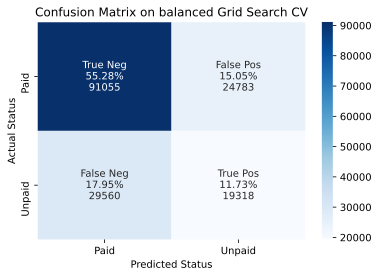

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

X_test = scaler.transform(test[features])
preds = clf.predict(X_test)

cf_matrix = confusion_matrix(test['status'], preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=plt.cm.Blues,xticklabels = ['Paid','Unpaid'], yticklabels = ['Paid','Unpaid'])
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix on balanced Grid Search CV')
plt.show(g);